In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


import os

dir_path = os.getcwd()

In [2]:
cores = {
    'verde': '#86bf8d',
    'azul': '#86b7bf',
    'vermelho': '#bf8c86'
}

bar_args_1 = {
    'color': '#bf8c86',
    'edgecolor': 'black',
    'linewidth': 0.3
}

bar_args_2 = {
    'color': '#86b7bf',
    'edgecolor': 'black',
    'linewidth': 0.3
}

In [3]:
df_train = pd.read_csv(os.path.join(dir_path, 'train.csv'))
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Análise exploratória dos dados

In [4]:
df_train.shape

(891, 12)

In [5]:
df_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

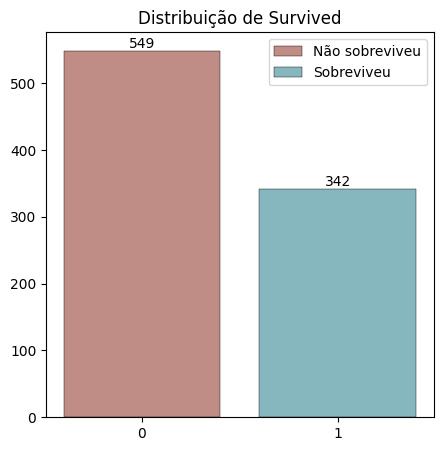

In [6]:
fix, ax = plt.subplots(figsize=(5,5))

counts = df_train["Survived"].value_counts()
rect_1 = ax.bar(x=0, height=counts[0], label='Não sobreviveu', **bar_args_1)
rect_2 = ax.bar(x=1, height=counts[1], label='Sobreviveu', **bar_args_2)
ax.legend()
ax.set_xticks([0,1], [0,1])
ax.set_title('Distribuição de Survived')
ax.bar_label(rect_1)
ax.bar_label(rect_2)

plt.show()

In [7]:
df_train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

#### Insights
1. Temos uma amostra de 891 linhas e 12 colunas
2. Das 891 pessoas, 549 não sobreviveram e 342 sobreviveram

In [8]:
df_train["Survived"].value_counts()[0]

549

### 1. Análise das colunas numéricas

#### 1.1 Age

In [9]:
print(f"{df_train['Age'].isnull().sum()} valores nulos de {df_train.shape[0]}. Taxa de nulos: {np.round((df_train['Age'].isnull().sum() * 100/df_train.shape[0]))}%")

177 valores nulos de 891. Taxa de nulos: 20.0%


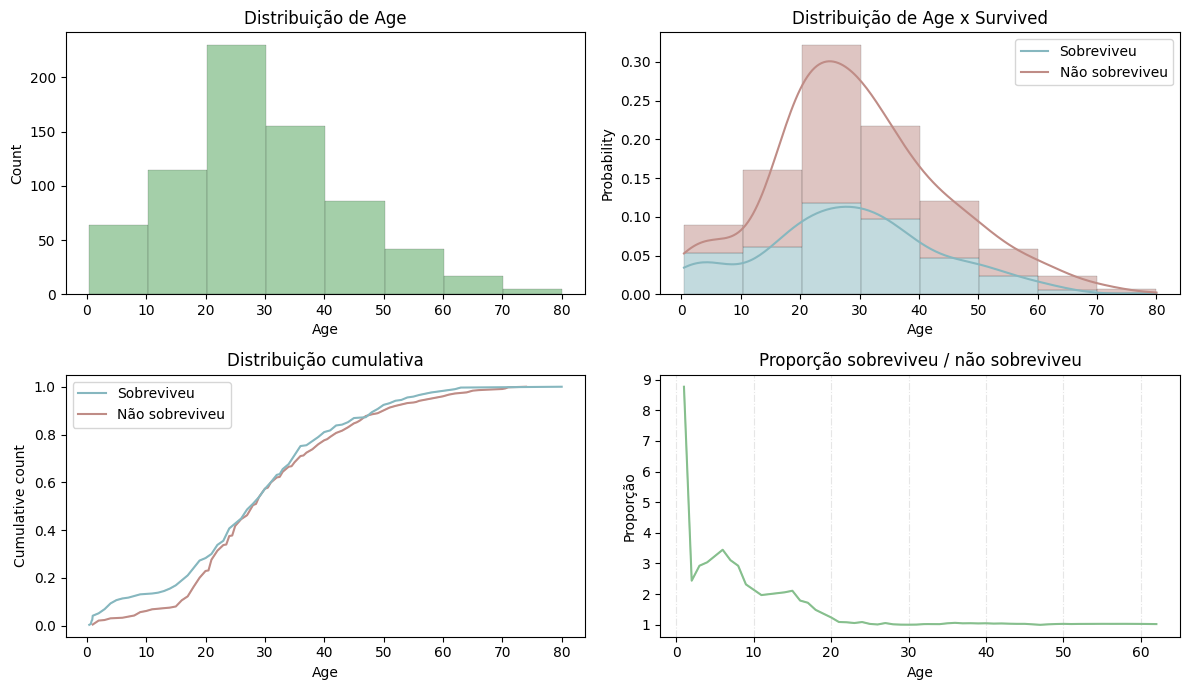

In [10]:
mosaic = '''
AB
CC
'''

fig, ax = plt.subplots(2,2 , figsize=(12,7))

# Figura 1
sns.histplot(df_train['Age'], bins=8, stat='count', linewidth=0.1, ax=ax[0][0], color=cores['verde'])
ax[0][0].set_title('Distribuição de Age')

# Figura 2
sns.histplot(data=df_train, x='Age',kde=True, hue='Survived',bins=8, stat='probability', linewidth=0.1, ax=ax[0][1], palette=[cores['vermelho'], cores['azul']], multiple='stack')
ax[0][1].set_title('Distribuição de Age x Survived')
ax[0][1].legend(['Sobreviveu', 'Não sobreviveu'])

df_0 = df_train[df_train['Survived'] == 0].sort_values('Age').reset_index(drop=True).dropna(subset='Age').copy()
df_0['Cumulative count'] = df_0['Age'].apply(lambda x: df_0[df_0['Age'] <= x].shape[0]/ df_0.shape[0])

df_1 = df_train[df_train['Survived'] == 1].sort_values('Age').reset_index(drop=True).dropna(subset='Age').copy()
df_1['Cumulative count'] = df_1['Age'].apply(lambda x: df_1[df_1['Age'] <= x].shape[0]/ df_1.shape[0])

df_cumulative = pd.concat([df_0, df_1])[['Survived', 'Age', 'Cumulative count']].reset_index(drop=True)
df_cumulative

# Figura 3
sns.lineplot(data=df_cumulative, x='Age', y='Cumulative count', hue='Survived', palette=[cores['vermelho'], cores['azul']], ax=ax[1][0]).set_title('Distribuição cumulativa')
ax[1][0].legend(handles=ax[1][0].get_legend_handles_labels()[0][::-1], labels=['Sobreviveu', 'Não sobreviveu'])
sns.lineplot(data=(df_cumulative[df_cumulative['Survived'] == 1].set_index('Age')['Cumulative count'] / df_cumulative[df_cumulative['Survived'] == 0].set_index('Age')['Cumulative count']).dropna(), ax=ax[1][1], color=cores['verde']).set_title('Proporção sobreviveu / não sobreviveu')
ax[1][1].grid(axis='x', linestyle='-.', color='#e6e6e6')
ax[1][1].set_ylabel('Proporção')

fig.tight_layout()

##### Insights
1. A distribuição da idade mostra que a maioria das pessoas no Titanic tem entre 20-30 anos
2. A distribuição cumulativa mostra que, bebês, crianças e adolescentes tiveram maior taxa de sobrevivência
3. Alto percentual de valores faltantes. Será discutido posteriormente a estratégia para tratar este caso

#### 1.2 Fare

In [11]:
df_train['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [12]:
df_train['Fare'].median()

14.4542

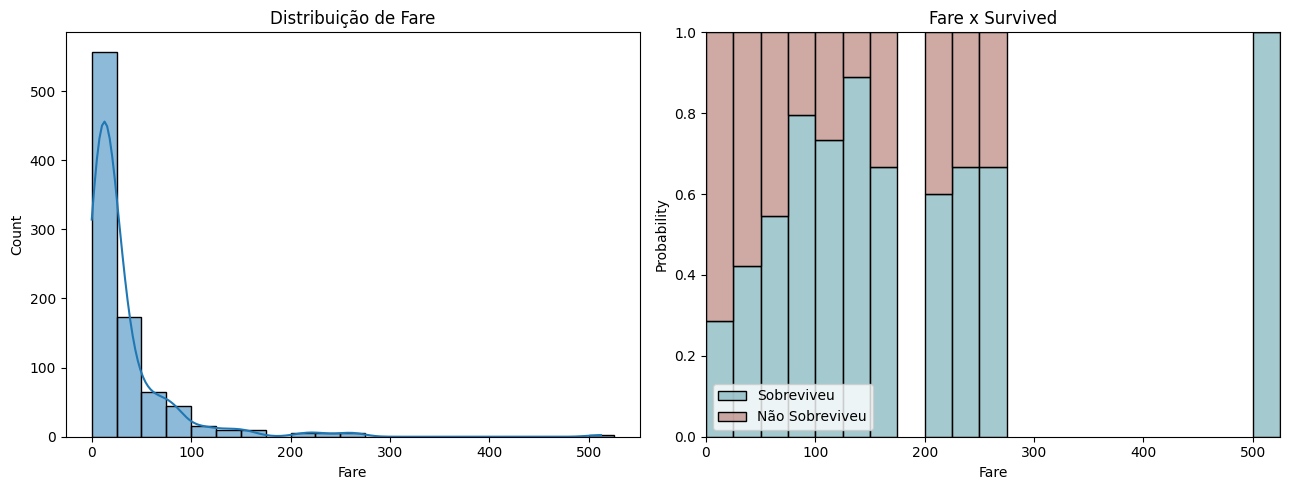

In [13]:
fig, ax = plt.subplots(1,2,figsize=(13,5))

# Figura 1
sns.histplot(data=df_train, x='Fare', ax=ax[0], kde=True, binwidth=25).set_title('Distribuição de Fare')

# Figura 2
sns.histplot(data=df_train, x='Fare', hue='Survived', ax=ax[1], palette=[cores['vermelho'], cores['azul']], binwidth=25, multiple='fill', stat='probability').set_title('Fare x Survived')
ax[1].legend(['Sobreviveu', 'Não Sobreviveu'])

fig.tight_layout()

##### Insights
1. Até a faixa de 100, houve um padrão forte de crescimento da probabilidade de sobrevivência com o aumento do valor
2. Estabilização da probabilidade, mantendo-se entre os 70% e 80%, após o valor 100

### 2. Análise das colunas categóricas

#### 2.1 Pclass

In [14]:
df_train['Pclass'].isnull().sum()

0

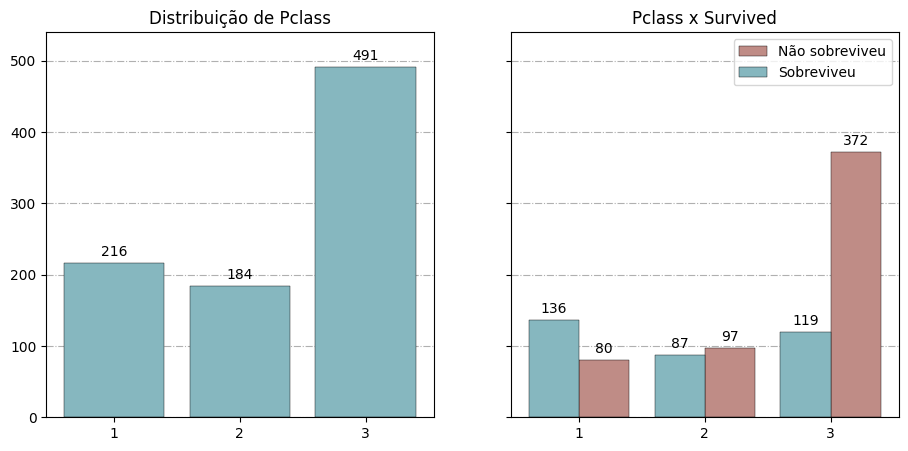

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True)
pclass_valuecounts = df_train[['Pclass', 'Survived']].value_counts().sort_values().reset_index().rename(columns={0: 'Count'})
pclass_list = pclass_valuecounts['Pclass'].unique()

# Figura 1
for pclass in pclass_list:
    count_pclass = pclass_valuecounts[pclass_valuecounts['Pclass'] == pclass].sum()['Count']
    rect = ax[0].bar(x = pclass, height=count_pclass, **bar_args_2)
    ax[0].bar_label(rect, padding=3)
ax[0].set_xticks(pclass_list)
ax[0].set_title('Distribuição de Pclass')
ax[0].margins(y=0.1)
ax[0].set_axisbelow(True)
ax[0].yaxis.grid(linestyle='-.')

# Figura 2
width = 0.4
for pclass in pclass_list:
    rect_1 = ax[1].bar(x = pclass + width / 2, height=pclass_valuecounts[(pclass_valuecounts['Pclass'] == pclass) & (pclass_valuecounts['Survived'] == 0)]['Count'].values[0], width = width, label='Não sobreviveu', **bar_args_1)
    rect_2 = ax[1].bar(x = pclass - width / 2, height=pclass_valuecounts[(pclass_valuecounts['Pclass'] == pclass) & (pclass_valuecounts['Survived'] == 1)]['Count'].values[0], width = width, label='Sobreviveu', **bar_args_2)
    ax[1].bar_label(rect_1, padding=3)
    ax[1].bar_label(rect_2, padding=3)
ax[1].set_xticks(pclass_list)
ax[1].set_title('Pclass x Survived')
ax[1].legend(handles=[rect_1, rect_2])
ax[1].margins(y=0.1)
ax[1].set_axisbelow(True)
ax[1].yaxis.grid(linestyle='-.')
plt.show()

##### Insights
1. Quem utilizou o ticket 1 para embarcar teve maior índice de sobreviventes
2. Quem utilizou o ticket 3 para embarcar teve maior índice de não sobreviventes

### 2.2 SibSp e Parch

In [16]:
print(f"Nulos em SibSp: {df_train['SibSp'].isnull().sum()}. Nulos em Parch: {df_train['Parch'].isnull().sum()}")

Nulos em SibSp: 0. Nulos em Parch: 0


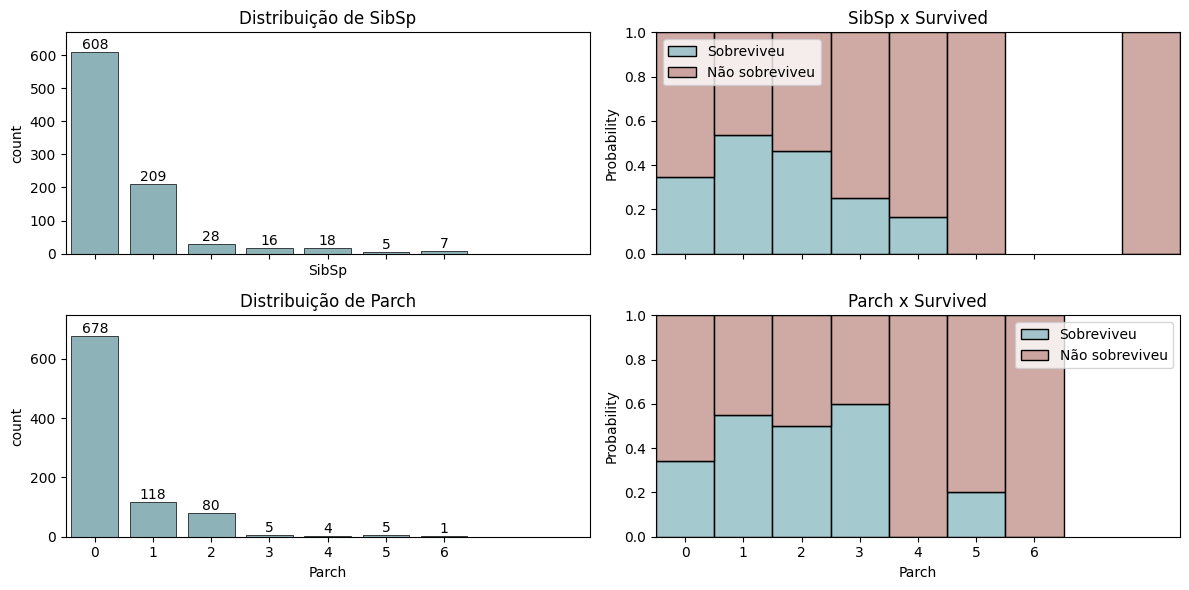

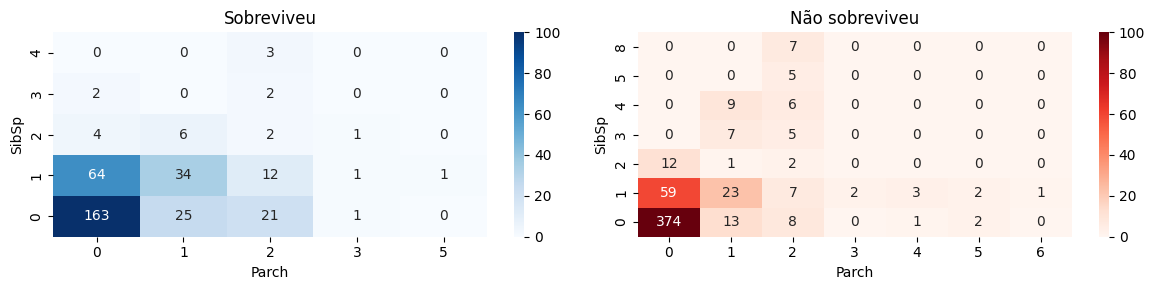

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(12,6), sharex=True)

# Figura 1
rect_1 = sns.countplot(data=df_train, x='SibSp', ax=ax[0][0], color=cores['azul'], linewidth=0.5, edgecolor='black').set_title('Distribuição de SibSp')
[ax[0][0].bar_label(bars) for bars in ax[0][0].containers]
ax[0][0].margins(y=0.1)

# Figura 2
sns.histplot(data=df_train, x='SibSp', hue='Survived', discrete=True, stat='probability', multiple='fill', palette=[cores['vermelho'], cores['azul']], ax=ax[0][1]).set_title('SibSp x Survived')
ax[0][1].legend(['Sobreviveu','Não sobreviveu'])

# Figura 3
sns.countplot(data=df_train, x='Parch', ax=ax[1][0], color=cores['azul'], linewidth=0.5, edgecolor='black').set_title('Distribuição de Parch')
[ax[1][0].bar_label(bars) for bars in ax[1][0].containers]
ax[1][0].margins(y=0.1)

# Figura 4
sns.histplot(data=df_train, x='Parch', hue='Survived', discrete=True, stat='probability', multiple='fill', palette=[cores['vermelho'], cores['azul']], ax=ax[1][1]).set_title('Parch x Survived')
ax[1][1].legend(['Sobreviveu','Não sobreviveu'])

fig.tight_layout()

fig_2, ax_2 = plt.subplots(1, 2, figsize=(12,3))

# Figura 5
sns.heatmap(data=df_train[df_train['Survived'] == 1].groupby(['SibSp','Parch']).size().unstack(fill_value=0), ax=ax_2[0], vmax=100, cmap='Blues', annot=True, fmt='g').set_title('Sobreviveu')
ax_2[0].invert_yaxis()

# Figura 6
sns.heatmap(data=df_train[df_train['Survived'] == 0].groupby(['SibSp','Parch']).size().unstack(fill_value=0), ax=ax_2[1], vmax=100, cmap='Reds', annot=True, fmt='g').set_title('Não sobreviveu')
ax_2[1].invert_yaxis()

fig_2.tight_layout()



#### Insights
1. Maioria das pessoas viajaram sem familiares (irmãos, cônjuges, pais ou filhos)
2. Viajar acompanhado trouxe uma maior probabilidade de sobrevivência
3. SibSp e Parch tem um comportamento bem parecido quando relacionado ao nosso objetivo Survived, indicando uma possível junção na etapa de feature engineering

### 2.3 Name

In [18]:
df_train.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
224,225,1,1,"Hoyt, Mr. Frederick Maxfield",male,38.0,1,0,19943,90.0000,C93,S
655,656,0,2,"Hickman, Mr. Leonard Mark",male,24.0,2,0,S.O.C. 14879,73.5000,NaN,S
261,262,1,3,"Asplund, Master. Edvin Rojj Felix",male,3.0,4,2,347077,31.3875,NaN,S
834,835,0,3,"Allum, Mr. Owen George",male,18.0,0,0,2223,8.3000,NaN,S
877,878,0,3,"Petroff, Mr. Nedelio",male,19.0,0,0,349212,7.8958,NaN,S


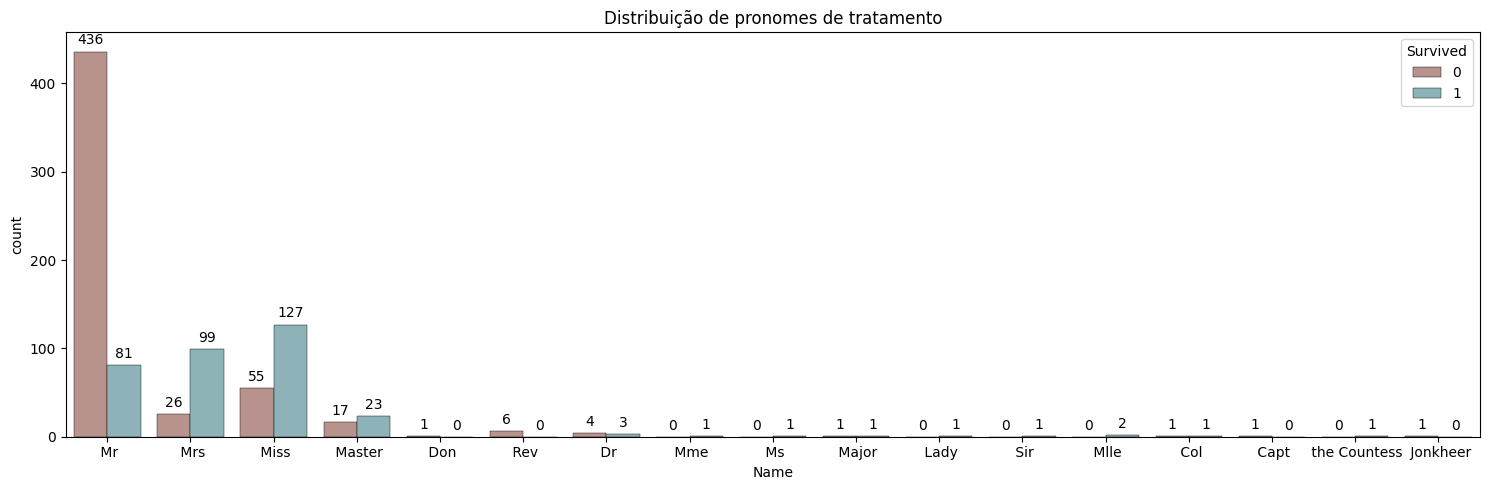

In [19]:
fig, ax = plt.subplots(figsize=(15,5))
rect_1 = sns.countplot(x=df_train['Name'].apply(lambda x: x.split(',')[1].split('.')[0]), ax=ax, hue=df_train['Survived'], palette=[cores['vermelho'], cores['azul']], linewidth=0.3, edgecolor='black').set_title('Distribuição de pronomes de tratamento')

# Adicionar bar labels
for p in ax.patches:
    height = p.get_height()
    ax.annotate("{}".format(int(height)), xy=(p.get_x()+p.get_width()/2, height), xytext=(0,3), textcoords="offset points", ha="center", va="bottom")

fig.tight_layout()

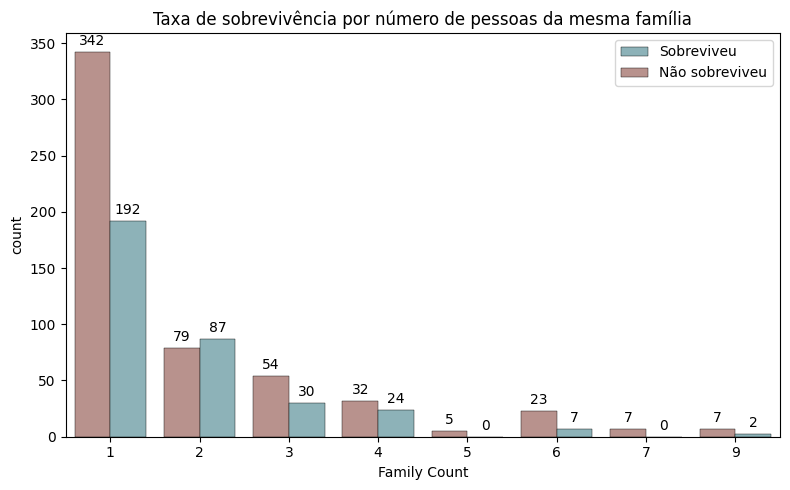

In [20]:
df_name = df_train[['PassengerId', 'Name', 'Sex', 'Age', 'Survived']].copy()
df_name['Last Name'] = df_name['Name'].apply(lambda name: name.split(',')[0])
family_count = df_name.groupby('Last Name')['PassengerId'].count()
df_name['Family Count'] = df_name['Last Name'].apply(lambda name: family_count[name])

fig, ax = plt.subplots(figsize=(8,5))
sns.countplot(data=df_name, x='Family Count', hue='Survived', palette=[cores['vermelho'], cores['azul']], ax=ax, linewidth=0.3, edgecolor='black').set_title('Taxa de sobrevivência por número de pessoas da mesma família')
ax.legend(handles=ax.get_legend_handles_labels()[0][::-1], labels=['Sobreviveu', 'Não sobreviveu'])

for p in ax.patches:
    height = p.get_height()
    ax.annotate("{}".format(int(height)), xy=(p.get_x()+p.get_width()/2, height), xytext=(0,3), textcoords="offset points", ha="center", va="bottom")

fig.tight_layout()

#### Insights
1. O gráfico acima mostra que pessoas com pronome de tratamento feminino tem maior taxa de sobrevivência.
2. Considerando uma família sendo um grupo de pessoas com mesmo último nome, apenas os grupos de 2 pessoas tiveram um número maior de sobreviventes

### 2.4 Sex

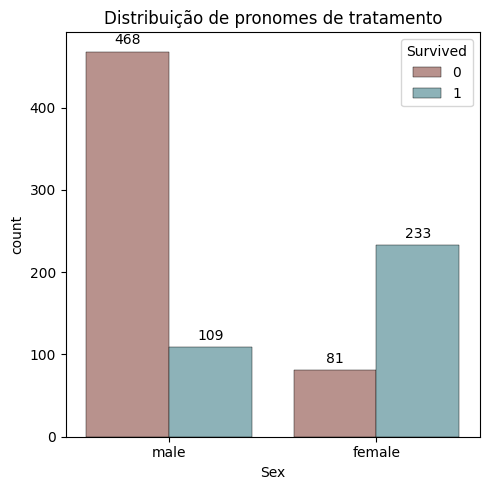

In [21]:
fig, ax = plt.subplots(figsize=(5,5))
rect_1 = sns.countplot(data=df_train, x='Sex', ax=ax, hue='Survived', palette=[cores['vermelho'], cores['azul']], linewidth=0.3, edgecolor='black').set_title('Distribuição de pronomes de tratamento')

# Adicionar bar labels
for p in ax.patches:
    height = p.get_height()
    ax.annotate("{}".format(int(height)), xy=(p.get_x()+p.get_width()/2, height), xytext=(0,3), textcoords="offset points", ha="center", va="bottom")

fig.tight_layout()

#### Insights
1. Mulheres tiveram maior índice de sobrevivência

### 2.5 Ticket, Cabin e Embarked

In [22]:
# Contagem de valores nulos
print('Contagem de nulos:\n')
print(df_train[['Ticket', 'Cabin', 'Embarked']].apply(lambda x: x.isnull().sum()))

Contagem de nulos:

Ticket        0
Cabin       687
Embarked      2
dtype: int64


TICKET:

Valores únicos -> 681


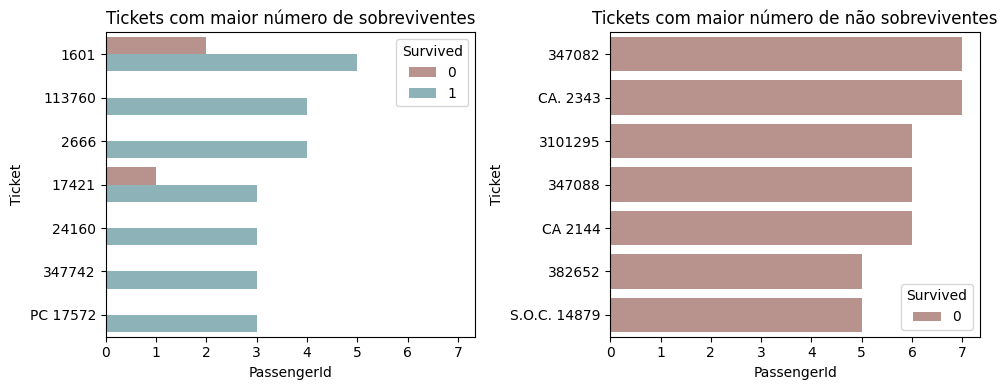

In [23]:
# Ticket
print('TICKET:\n')
print('Valores únicos -> ' + str(df_train['Ticket'].nunique()))

fig, ax = plt.subplots(1,2,figsize=(10,4), sharex=True)
df_ticket = df_train.groupby(['Ticket', 'Survived'], as_index=False)['PassengerId'].count()
sns.barplot(data=df_ticket.loc[df_ticket['Ticket'].isin(df_ticket[df_ticket['Survived'] == 1].sort_values(by='PassengerId', ascending=False).head(7)['Ticket'])].sort_values(by=['Survived', 'PassengerId'], ascending=False), y='Ticket', x='PassengerId', hue='Survived', ax=ax[0], palette=[cores['vermelho'], cores['azul']]).set_title('Tickets com maior número de sobreviventes')
sns.barplot(data=df_ticket.loc[df_ticket['Ticket'].isin(df_ticket[df_ticket['Survived'] == 0].sort_values(by='PassengerId', ascending=False).head(7)['Ticket'])].sort_values(by=['Survived', 'PassengerId'], ascending=False), y='Ticket', x='PassengerId', hue='Survived', ax=ax[1], palette=[cores['vermelho'], cores['azul']]).set_title('Tickets com maior número de não sobreviventes')

fig.tight_layout()

CABIN:

Valores únicos -> 147
Valores duplicados -> 57


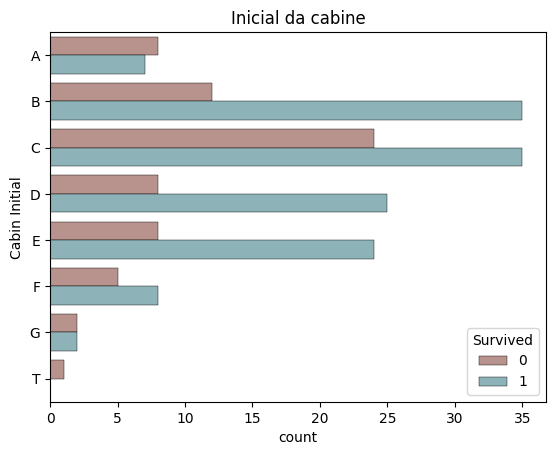

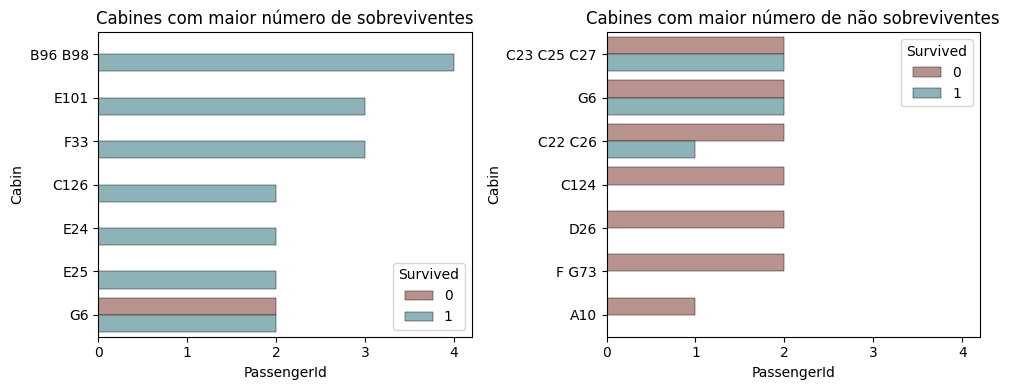

In [24]:
# Cabin
print('CABIN:\n')
print('Valores únicos -> ' + str(df_train['Cabin'].nunique()))
print('Valores duplicados -> ' + str(df_train['Cabin'].dropna().duplicated().sum()))

df_cabin = df_train[['Cabin', 'Survived']].dropna()
df_cabin['Cabin Initial'] = df_cabin['Cabin'].apply(lambda cabin: cabin[0])
df_cabin['Cabin Quantity'] = df_cabin['Cabin'].apply(lambda cabin: len(cabin.split()))

sns.countplot(data=df_cabin.sort_values(by='Cabin Initial'), y='Cabin Initial', hue='Survived', palette=[cores['vermelho'], cores['azul']], edgecolor='black', linewidth=0.3).set_title('Inicial da cabine')

fig, ax = plt.subplots(1,2,figsize=(10,4), sharex=True)
df_cabin = df_train.groupby(['Cabin', 'Survived'], as_index=False)['PassengerId'].count()
sns.barplot(data=df_cabin.loc[df_cabin['Cabin'].isin(df_cabin[df_cabin['Survived'] == 1].sort_values(by='PassengerId', ascending=False).head(7)['Cabin'])].sort_values(by=['Survived', 'PassengerId'], ascending=False), y='Cabin', x='PassengerId', hue='Survived', ax=ax[0], palette=[cores['vermelho'], cores['azul']], edgecolor='black', linewidth=0.3).set_title('Cabines com maior número de sobreviventes')
sns.barplot(data=df_cabin.loc[df_cabin['Cabin'].isin(df_cabin[df_cabin['Survived'] == 0].sort_values(by='PassengerId', ascending=False).head(7)['Cabin'])].sort_values(by=['Survived', 'PassengerId'], ascending=False), y='Cabin', x='PassengerId', hue='Survived', ax=ax[1], palette=[cores['vermelho'], cores['azul']], edgecolor='black', linewidth=0.3).set_title('Cabines com maior número de não sobreviventes')

fig.tight_layout()

Embarked:
-  Valores: S, C, Q


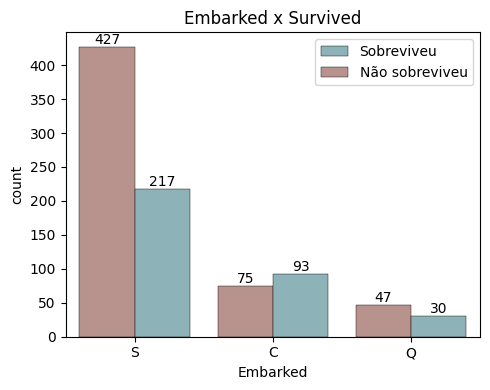

In [25]:
# Embarked
print('Embarked:')
print('-  Valores: ' + ', '.join(df_train['Embarked'].dropna().unique()))

fig, ax = plt.subplots(figsize=(5,4))

sns.countplot(data=df_train, x='Embarked', hue='Survived', ax=ax, palette=[cores['vermelho'], cores['azul']], edgecolor='black', linewidth=0.3).set_title('Embarked x Survived')
ax.legend(handles = ax.get_legend_handles_labels()[0][::-1], labels = ['Sobreviveu', 'Não sobreviveu'])

for p in ax.patches:
    height = p.get_height()
    ax.annotate(int(height), xy=[p.get_x() + (p.get_width() / 2),height],ha='center', va='bottom')

fig.tight_layout()

#### Insights
1. Ticket e Cabin podem indicar pessoas que embarcaram juntas
2. Ticket possui muitos valores únicos, dificultando a categorização da variável
3. Pessoas que embarcaram em cabines com inicial A tiveram menor taxa de sobrevivência
4. Cabin possui muitos valores nulos
5. Pessoas que embarcaram em 'C' tiveram maior taxa de sobrevivência

# Tratamento de dados
Serão feitas 2 correções a respeito de valores faltantes:

1. Será utilizada a metodologia da imputação de dados via KNN para a coluna 'Age', considerando as colunas 'Fare' e 'Survived'
2. Será utilizada a metodologia da imputação de dados via moda para a coluna 'Embarked', visto que tem somente 2 registros nulos.
3. Ticket e cabin são variáveis difíceis de utilizar para construir o modelo (por questões de muitos valores únicos e muitos valores faltantes, respectivamente).

In [56]:
def data_cleaning(df):
    df_clean = df.copy()

    knn_imputer = KNNImputer()
    df_clean['Age'] = knn_imputer.fit_transform(df_clean[['Age', 'Fare']])[:, 0]

    moda_imputer = SimpleImputer(strategy='most_frequent')
    df_clean['Embarked'] = moda_imputer.fit_transform(df_clean[['Embarked']])

    df_clean = df_clean.drop(columns=['PassengerId', 'Ticket', 'Cabin'])

    return df_clean

In [57]:
df_tratado = data_cleaning(df_train)
df_tratado

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,13.0000,S
887,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,30.0000,S
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1,2,23.4500,S
889,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,30.0000,C


# Feature engineering

A partir das primeiras impressões obtidas na análise exploratória, vamos tentar aprofundar alguns insights e entender relações entre as variáveis.

1. SibSp e Parch indicam familiares, então juntaremos as colunas
2. Será criada uma coluna com o pronome de tratamento baseado na coluna 'Name'. Pronomes pouco frequentes na base de dados será tratado como 'Others'
3. A coluna 'Name', ao analisar o pronome de tratamento, converge bastante com a coluna 'Sex', então será dropada.

Obs.:
1. 'Age' e 'Fare' possui informações importantes implícitas em suas distribuições. Um teste válido seria categorizar estas colunas em faixas de valores
2. Ponto de atenção: o pronome de tratamento pode ter redundância com a variável 'Sex'

In [58]:
def data_engineering(df):
    df_eng = df.copy()

    df_eng['Family count'] = df_eng['SibSp'] + df_eng['Parch']
    df_eng = df_eng.drop(columns=['Name', 'SibSp', 'Parch'])

    return df_eng

In [59]:
df_feat = data_engineering(df_tratado)
df_feat

,Survived,Pclass,Sex,Age,Fare,Embarked,Family count
0,0,3,male,22.0,7.2500,S,1
1,1,1,female,38.0,71.2833,C,1
2,1,3,female,26.0,7.9250,S,0
3,1,1,female,35.0,53.1000,S,1
4,0,3,male,35.0,8.0500,S,0
...,...,...,...,...,...,...,...
886,0,2,male,27.0,13.0000,S,0
887,1,1,female,19.0,30.0000,S,0
888,0,3,female,28.0,23.4500,S,3
889,1,1,male,26.0,30.0000,C,0


# Pré-processamento

Nesta fase, as colunas serão normalizadas e rotuladas de acordo com a necessidade.

1. Rotular: Sex, Embarked
2. Normalizar: Age, Fare

In [60]:
def preprocess(df):
    df_preprocessing = df.copy()

    columns_category = ['Pclass', 'Sex', 'Embarked']
    columns_label = ['Sex', 'Embarked']
    columns_normalize = ['Age', 'Fare']
    
    label_encoder = LabelEncoder()
    for c in columns_label:
        df_preprocessing[c] = label_encoder.fit_transform(df_preprocessing[c])

    scaler = StandardScaler()
    for c in columns_normalize:
        df_preprocessing[c] = scaler.fit_transform(df_preprocessing[[c]]).ravel()

    hot_encoder = make_column_transformer((OneHotEncoder(handle_unknown='ignore'), columns_category), remainder='passthrough')
    array_encoded = hot_encoder.fit_transform(df_preprocessing[columns_category])
    df_category = pd.DataFrame(array_encoded, columns=hot_encoder.get_feature_names_out(), index=df_preprocessing.index)
    df_preprocessing = df_preprocessing.merge(df_category, right_index=True, left_index=True, how='left').drop(columns=['Pclass', 'Sex', 'Embarked'])

    return df_preprocessing

# Modelo classificador e avaliação

Nesta fase, utilizaremos 3 algoritmos para construir nosso modelo preditivo.

1. Floresta randômica
2. Máquina de vetor de suporte (SVM)
3. Regressão logística

Para avaliar o modelo, será utilizado por cross-validation, particionando a base de dados em 5 subconjuntos. A média da avaliação nas 5 previsões será o modelo oficial para submeter na competição.

In [61]:
df_preprocessing = df_feat.copy()

X_train, x_test, Y_train, y_test = train_test_split(df_preprocessing.iloc[:, 1:], df_preprocessing['Survived'], train_size=0.7)

preprocess(X_train)

kfolds = KFold(n_splits=5, shuffle=True, random_state=20)

# Floresta randômica
rfc = RandomForestClassifier(random_state=2)

# SVM
svm = SVC(random_state=1)

# Regressão logística
log = LogisticRegression(random_state=2)

df_scores = pd.DataFrame()

df_scores['Floresta randômica'] = cross_val_score(rfc, preprocess(df_preprocessing.iloc[:, 1:]), df_preprocessing['Survived'], cv=kfolds)
df_scores['SVM'] = cross_val_score(svm, preprocess(df_preprocessing.iloc[:, 1:]), df_preprocessing['Survived'], cv=kfolds)
df_scores['Regressão logística'] = cross_val_score(log, preprocess(df_preprocessing.iloc[:, 1:]), df_preprocessing['Survived'], cv=kfolds)

df_scores = df_scores.T
df_scores['Média'] = df_scores.mean(axis=1)
df_scores

,0,1,2,3,4,Média
Floresta randômica,0.804469,0.808989,0.820225,0.825843,0.797753,0.811456
SVM,0.849162,0.786517,0.797753,0.820225,0.837079,0.818147
Regressão logística,0.826816,0.735955,0.803371,0.808989,0.814607,0.797947


# Conclusão

Com uma média de 81,8%, o modelo SVM foi o que melhor se adaptou ao conjunto de dados. Logo, será utilizado no envio do modelo para a competição.

In [62]:
df_test = pd.read_csv(os.path.join(dir_path, 'test.csv'))
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [73]:
df_clean = data_cleaning(df_test)
df_clean.loc[df_clean['Fare'].isnull(), 'Fare'] = df_clean['Fare'].mean()
df_test_feat = data_engineering(df_clean)
df_test_preprocess = preprocess(df_test_feat)

,Age,Fare,Family count,onehotencoder__Pclass_1,onehotencoder__Pclass_2,onehotencoder__Pclass_3,onehotencoder__Sex_0,onehotencoder__Sex_1,onehotencoder__Embarked_0,onehotencoder__Embarked_1,onehotencoder__Embarked_2
0,0.372708,-0.498407,0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,1.343751,-0.513274,1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
2,2.509003,-0.465088,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,-0.209918,-0.483466,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,-0.598336,-0.418471,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
413,-0.334212,-0.494448,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
414,0.722283,1.313753,0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
415,0.683442,-0.508792,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
416,-0.334212,-0.494448,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [85]:
svm.fit(preprocess(df_preprocessing.iloc[:, 1:]), df_preprocessing['Survived'])
df_submit = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': svm.predict(df_test_preprocess)})
df_submit.to_csv(os.path.join(dir_path, 'submission.csv'), index=False)
df_submit

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
